In [43]:
# Importing necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Define paths for images and labels
train_image_dir = "BoneFractureYolo8/train/images"  # Replace with the actual path to the train image folder
train_label_dir = "BoneFractureYolo8/train/labels"  # Replace with the actual path to the train label folder

# Check the number of images and labels
image_files = sorted([f for f in os.listdir(train_image_dir) if f.endswith('.jpg') or f.endswith('.png')])
label_files = sorted([f for f in os.listdir(train_label_dir) if f.endswith('.txt')])

print(f"Number of images: {len(image_files)}")
print(f"Number of labels: {len(label_files)}")

# Ensure that each image has a corresponding label file
assert len(image_files) == len(label_files), "Mismatch between number of images and labels!"
for img, lbl in zip(image_files, label_files):
    assert os.path.splitext(img)[0] == os.path.splitext(lbl)[0], f"Image {img} does not match label {lbl}!"

# Function to parse a single label file
def parse_label_file(label_path):
    """
    Parse a YOLO-style label file.
    Returns a list of dictionaries containing class and bounding box information.
    """
    with open(label_path, 'r') as file:
        lines = file.readlines()
        labels = []
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            labels.append({'class': class_id, 'bbox': bbox})
        return labels




Number of images: 3631
Number of labels: 3631


/var/folders/tm/0vpql0k50wn447kl5c5fttn00000gn/T/ipykernel_38332/20140177.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


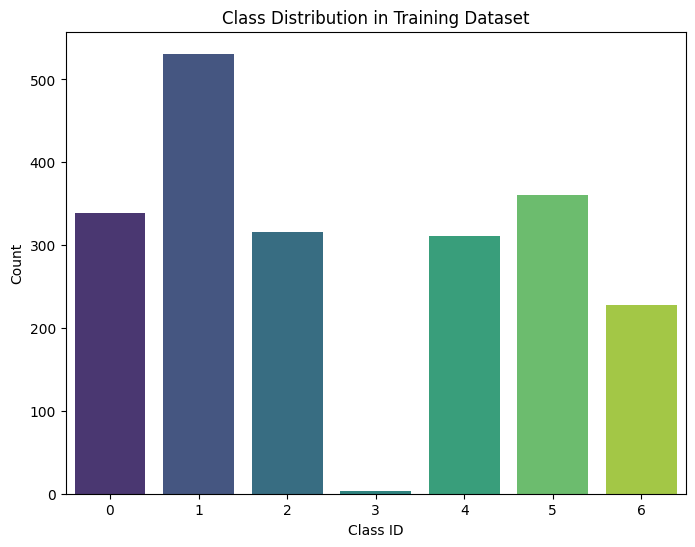

In [34]:
# Analyze class distribution in the training dataset
class_counts = {}
for label_file in label_files:
    label_path = os.path.join(train_label_dir, label_file)
    labels = parse_label_file(label_path)
    for label in labels:
        class_id = label['class']
        class_counts[class_id] = class_counts.get(class_id, 0) + 1

# Plot class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()

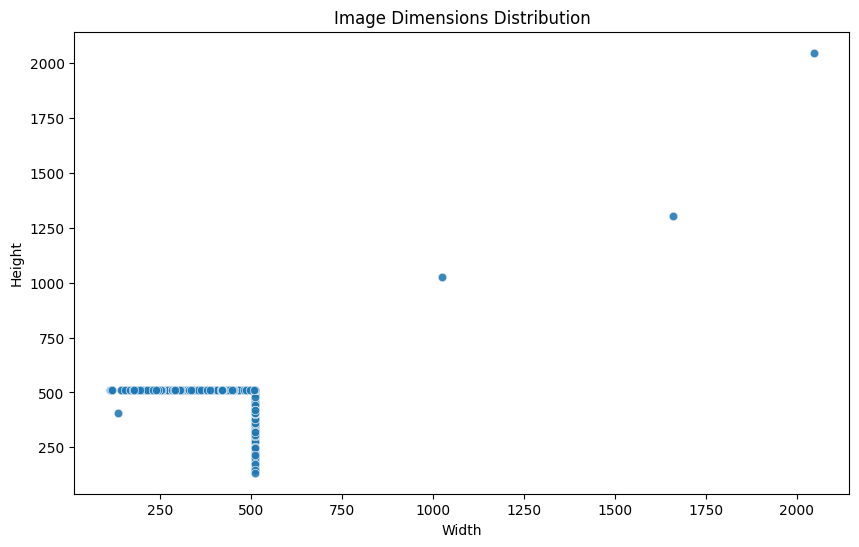

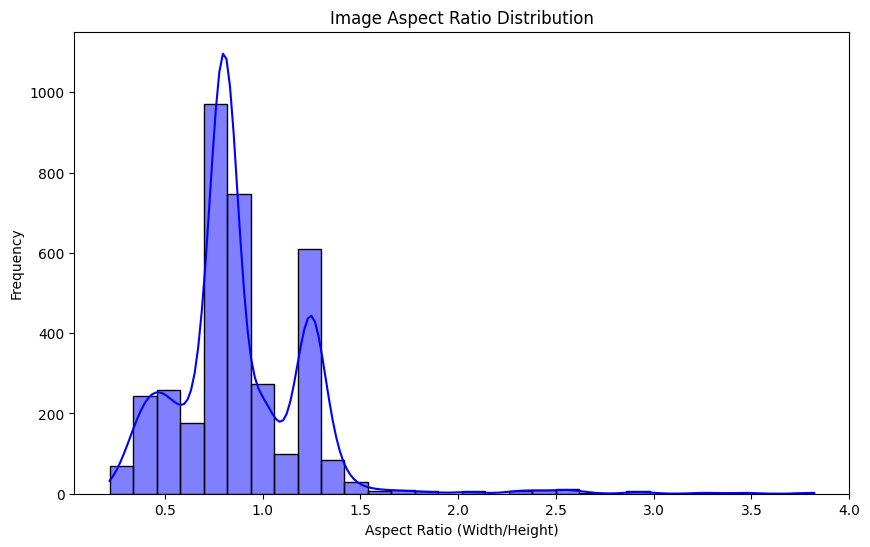

In [35]:

# Analyze image dimensions and aspect ratios
image_shapes = []
for img_file in image_files:
    img_path = os.path.join(train_image_dir, img_file)
    with Image.open(img_path) as img:
        image_shapes.append(img.size)  # (width, height)

# Convert image dimensions to DataFrame for analysis
image_data = pd.DataFrame(image_shapes, columns=['Width', 'Height'])
image_data['AspectRatio'] = image_data['Width'] / image_data['Height']

# Plot distribution of image dimensions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=image_data, x='Width', y='Height', alpha=0.5)
plt.title("Image Dimensions Distribution")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

# Plot aspect ratio distribution
plt.figure(figsize=(10, 6))
sns.histplot(image_data['AspectRatio'], bins=30, kde=True, color='blue')
plt.title("Image Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Frequency")
plt.show()


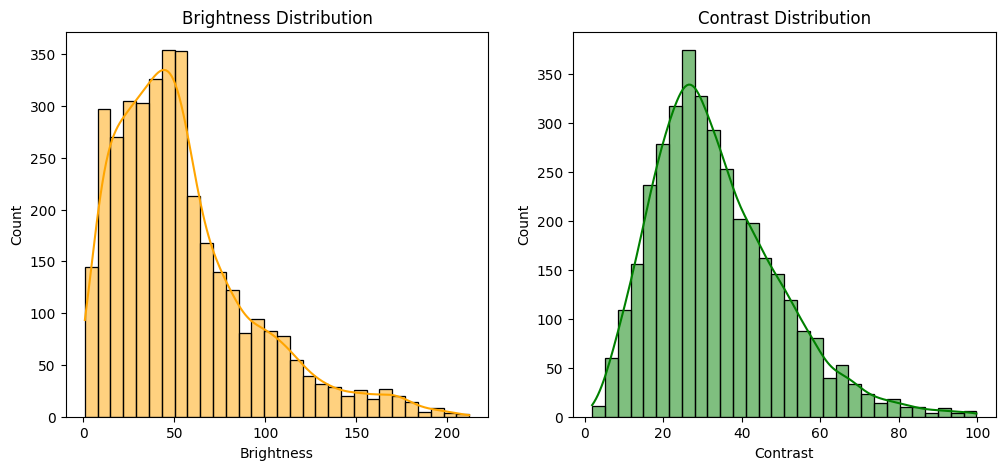

In [36]:
import numpy as np

# Function to compute brightness and contrast
def compute_brightness_contrast(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    brightness = np.mean(img)
    contrast = np.std(img)
    return brightness, contrast

# Compute brightness and contrast for all images
brightness_values = []
contrast_values = []

for img_file in image_files:
    img_path = os.path.join(train_image_dir, img_file)
    brightness, contrast = compute_brightness_contrast(img_path)
    brightness_values.append(brightness)
    contrast_values.append(contrast)

# Create DataFrame
brightness_contrast_df = pd.DataFrame({'Brightness': brightness_values, 'Contrast': contrast_values})

# Plot Brightness and Contrast Distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(brightness_contrast_df['Brightness'], bins=30, kde=True, color='orange')
plt.title("Brightness Distribution")
plt.xlabel("Brightness")

plt.subplot(1, 2, 2)
sns.histplot(brightness_contrast_df['Contrast'], bins=30, kde=True, color='green')
plt.title("Contrast Distribution")
plt.xlabel("Contrast")

plt.show()


In [37]:
import hashlib

# Function to compute hash of an image
def get_image_hash(image_path):
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

# Compute hashes for all images
image_hashes = {img_file: get_image_hash(os.path.join(train_image_dir, img_file)) for img_file in image_files}

# Find duplicates
hash_counts = pd.Series(image_hashes.values()).value_counts()
duplicates = hash_counts[hash_counts > 1]

if not duplicates.empty:
    print(f"Found {len(duplicates)} duplicate images.")
else:
    print("No duplicate images found.")


No duplicate images found.


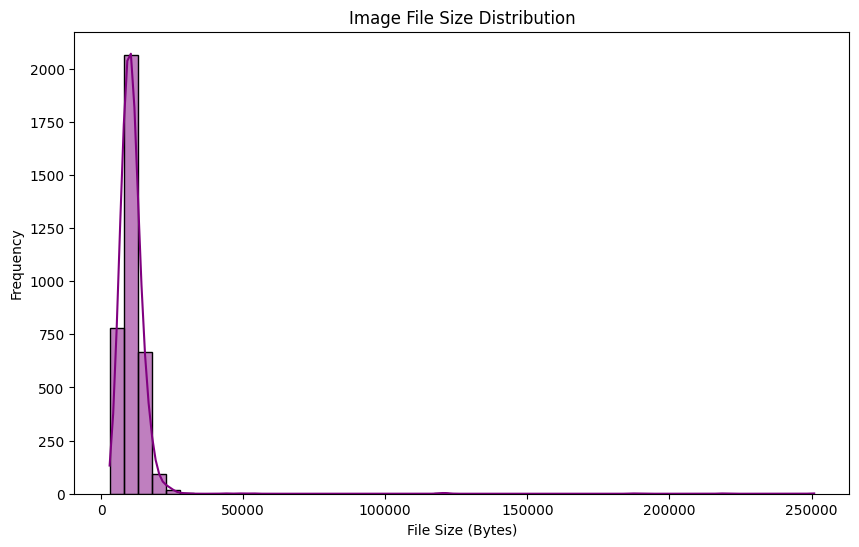

Number of very small images: 65
Number of very large images: 0


In [38]:
image_sizes = [os.path.getsize(os.path.join(train_image_dir, img_file)) for img_file in image_files]

# Plot file size distribution
plt.figure(figsize=(10, 6))
sns.histplot(image_sizes, bins=50, kde=True, color='purple')
plt.title("Image File Size Distribution")
plt.xlabel("File Size (Bytes)")
plt.ylabel("Frequency")
plt.show()

# Identify outliers (extremely small or large images)
small_images = [img for img, size in zip(image_files, image_sizes) if size < 5000]  # Less than 5 KB
large_images = [img for img, size in zip(image_files, image_sizes) if size > 5e6]  # Greater than 5MB

print(f"Number of very small images: {len(small_images)}")
print(f"Number of very large images: {len(large_images)}")


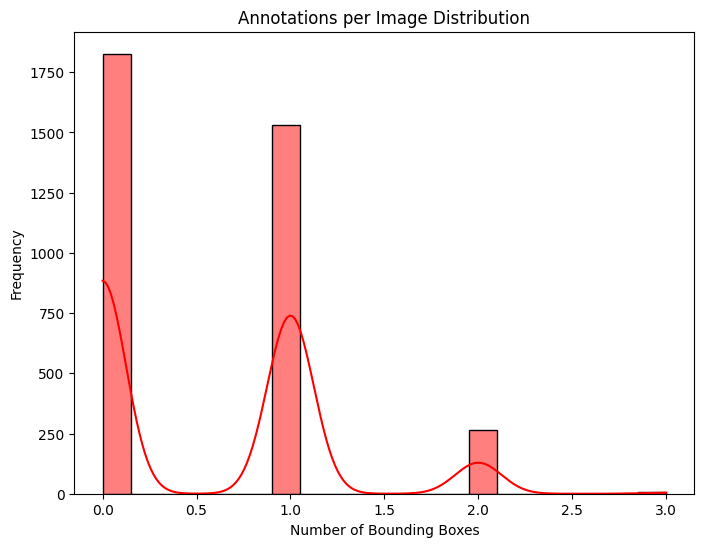

Average bounding boxes per image: 0.58
Max bounding boxes in an image: 3
Min bounding boxes in an image: 0


In [39]:
# Count number of annotations per image
annotations_per_image = [len(parse_label_file(os.path.join(train_label_dir, lbl))) for lbl in label_files]

# Plot distribution of annotations per image
plt.figure(figsize=(8, 6))
sns.histplot(annotations_per_image, bins=20, kde=True, color='red')
plt.title("Annotations per Image Distribution")
plt.xlabel("Number of Bounding Boxes")
plt.ylabel("Frequency")
plt.show()

print(f"Average bounding boxes per image: {np.mean(annotations_per_image):.2f}")
print(f"Max bounding boxes in an image: {max(annotations_per_image)}")
print(f"Min bounding boxes in an image: {min(annotations_per_image)}")


/var/folders/tm/0vpql0k50wn447kl5c5fttn00000gn/T/ipykernel_38332/2477048892.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(bbox_df['Width'], shade=True, color='blue', label="Width")
/var/folders/tm/0vpql0k50wn447kl5c5fttn00000gn/T/ipykernel_38332/2477048892.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(bbox_df['Height'], shade=True, color='orange', label="Height")


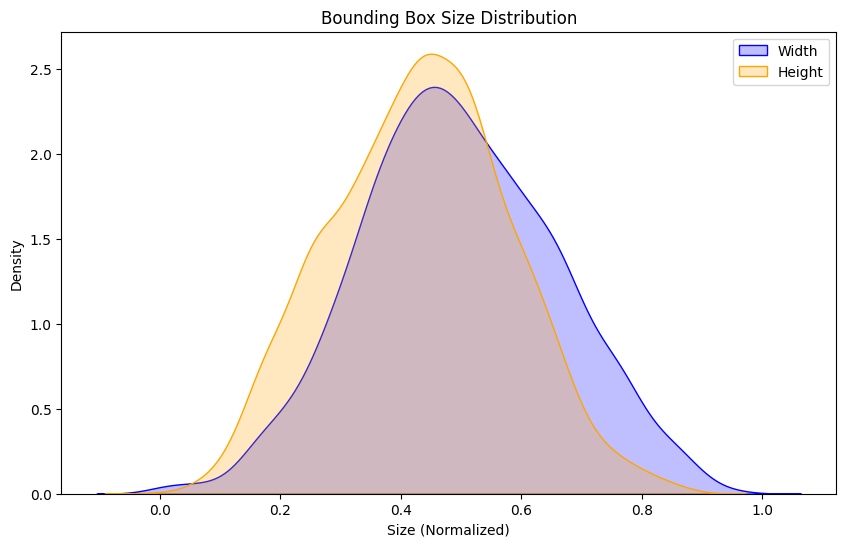

In [40]:
bbox_widths = []
bbox_heights = []

for lbl in label_files:
    label_path = os.path.join(train_label_dir, lbl)
    labels = parse_label_file(label_path)
    
    for label in labels:
        bbox_widths.append(label['bbox'][2])  # Normalized width
        bbox_heights.append(label['bbox'][3])  # Normalized height

# Convert to DataFrame
bbox_df = pd.DataFrame({'Width': bbox_widths, 'Height': bbox_heights})

# Plot bounding box size distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(bbox_df['Width'], shade=True, color='blue', label="Width")
sns.kdeplot(bbox_df['Height'], shade=True, color='orange', label="Height")
plt.title("Bounding Box Size Distribution")
plt.xlabel("Size (Normalized)")
plt.legend()
plt.show()


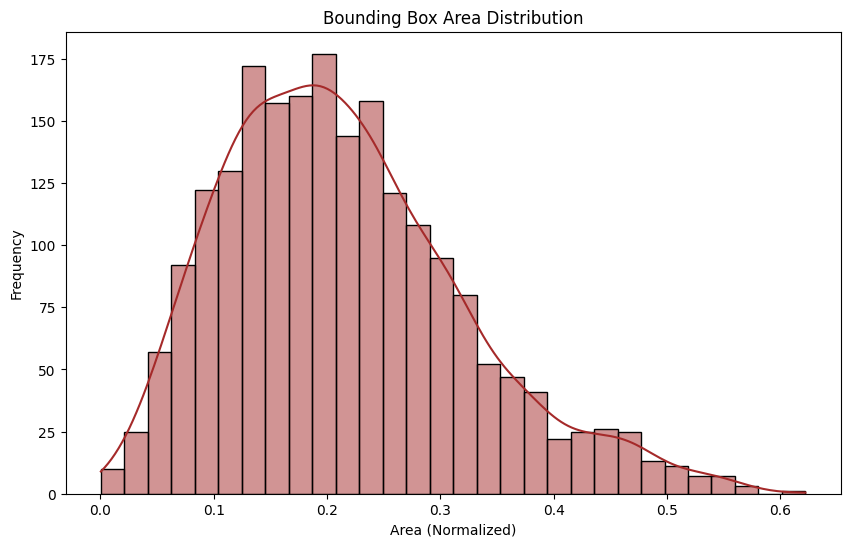

Average bounding box area: 0.215
Max bounding box area: 0.622
Min bounding box area: 0.001


In [41]:
bbox_areas = [(w * h) for w, h in zip(bbox_widths, bbox_heights)]

# Plot bounding box area distribution
plt.figure(figsize=(10, 6))
sns.histplot(bbox_areas, bins=30, kde=True, color='brown')
plt.title("Bounding Box Area Distribution")
plt.xlabel("Area (Normalized)")
plt.ylabel("Frequency")
plt.show()

print(f"Average bounding box area: {np.mean(bbox_areas):.3f}")
print(f"Max bounding box area: {max(bbox_areas):.3f}")
print(f"Min bounding box area: {min(bbox_areas):.3f}")


In [42]:
# Cell 9: Check for bounding boxes that are out of bounds

# Updated function to correctly parse labels
def parse_label_file(label_path):
    """
    Parse a YOLO-style label file.
    Returns a list of dictionaries containing class and bounding box information.
    """
    labels = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 5:  # Each line should have at least 5 values (class_id + bbox)
                print(f"Skipping malformed line in {label_path}: {line}")
                continue
            try:
                class_id = int(parts[0])
                bbox = list(map(float, parts[1:5]))  # Ensure only 4 bbox values are taken
                labels.append({'class': class_id, 'bbox': bbox})
            except ValueError as e:
                print(f"Error parsing line {line} in {label_path}: {e}")
    return labels

# Check for bounding boxes that are out of bounds
out_of_bounds_count = 0

for lbl in label_files:
    label_path = os.path.join(train_label_dir, lbl)
    labels = parse_label_file(label_path)
    
    for label in labels:
        x_center, y_center, bbox_width, bbox_height = label['bbox']
        
        # Check if bbox is out of bounds
        if (x_center < 0 or x_center > 1 or 
            y_center < 0 or y_center > 1 or 
            bbox_width < 0 or bbox_width > 1 or 
            bbox_height < 0 or bbox_height > 1):
            out_of_bounds_count += 1

print(f"Number of bounding boxes out of bounds: {out_of_bounds_count}")


Number of bounding boxes out of bounds: 0


In [44]:
import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image
import torch
from torch import nn
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files = sorted(glob.glob(os.path.join(root, mode) + '/images/*.jpg'))
        self.labels = {}
        self.boxes = {}
        assert len(self.files) > 0, "Make sure you downloaded the images!"

    def get_image(self, index):
        item = self.transform(Image.open(self.files[index % len(self.files)]))
        if item.shape[0] != 3: 
            item = item.repeat(3, 1, 1)
        # Old versions of PyTorch didn't support normalization for different-channeled images
        return item
    
    def get_labels(self, index):
        if index in self.labels:
            return self.labels[index]
        labels = []
        boxes = []
        text_file = self.files[index % len(self.files)].replace(".jpg", ".txt").replace("images", "labels")
        with open(text_file, mode="r") as f:
            lines = f.readlines()
            for line in lines:
                values = [float(value) for value in line.split()]
                label = int(values[0])
                coords = values[1:]
                coords = torch.reshape(torch.FloatTensor(coords), (int(len(coords)/2), 2))
                size = torch.tensor([self.get_image(index).shape[2], self.get_image(index).shape[1]])
                min_coords = torch.min(coords, dim=0).values * size
                max_coords = torch.max(coords, dim=0).values * size
                box = torch.cat((min_coords, max_coords), dim=0).tolist()
                labels.append(label)
                boxes.append(box)
        self.labels[index] = labels
        self.boxes[index] = torch.ByteTensor(boxes)
        return labels
    
    def get_boxes(self, index):
        if index in self.boxes:
            return self.boxes[index]
        _ = self.get_labels(index)
        return self.boxes[index]

    def __len__(self):
        return len(self.files)

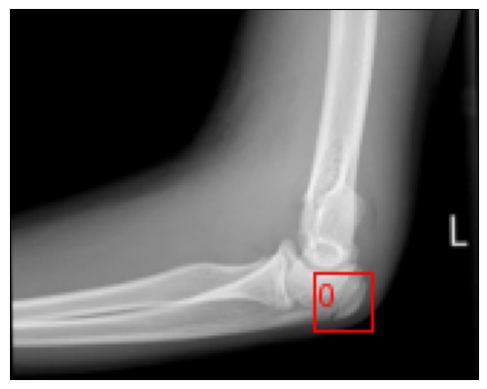

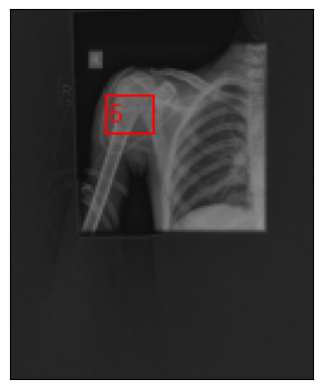

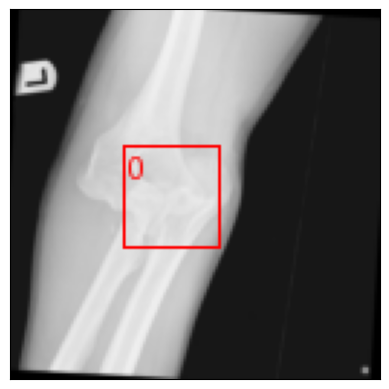

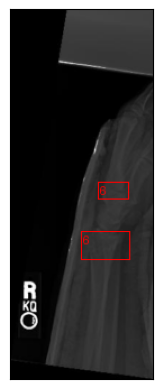

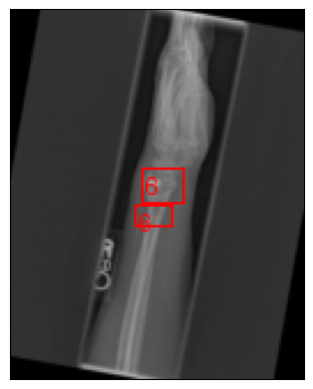

In [45]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

def show(imgs):
    """
    Display one or more images using Matplotlib.
    """
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

load_shape = 128

transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.ToTensor(),
])

dataset = ImageDataset("BoneFractureYolo8", transform=transform)

# Visualize bounding boxes for specific indices in the dataset
for index in [8, 1264, 5, 876, 15]:
    # Get image and convert to uint8 format
    img = F.convert_image_dtype(dataset.get_image(index), dtype=torch.uint8)
    
    # Draw bounding boxes on the image
    drawn_boxes = draw_bounding_boxes(
        img,
        boxes=dataset.get_boxes(index),  # Bounding box coordinates
        colors="red",                   # Box color
        labels=[str(x) for x in dataset.get_labels(index)]  # Class labels
    )
    
    # Display the image with bounding boxes
    show(drawn_boxes)
